## Week 5: Knowledge Distillation Lab

Welcome to this lab! We will talk about Knowledge Distillation (KD) in NLP!

The objectives of this lab are as follow:

1. Make you folks understand better about KD! Feel free to ask and discuss, we are here to learn more!
2. You got the general idea off this topic? Well, you need to exercise to have a better understanding! By the end, you know the basic idea how to implement KD using your own hand!

## Tools

Here, we use these library to implement the learning algorithm:
1. `pytorch`
2. `transformers`: Library to download a pre-trained model
3. `lightning`: Tools to make training easier and no boilerplate
4. `datasets`: load data uploaded from Huggingface
5. `dvc`: model versioning!

## Motivation (Refresher)

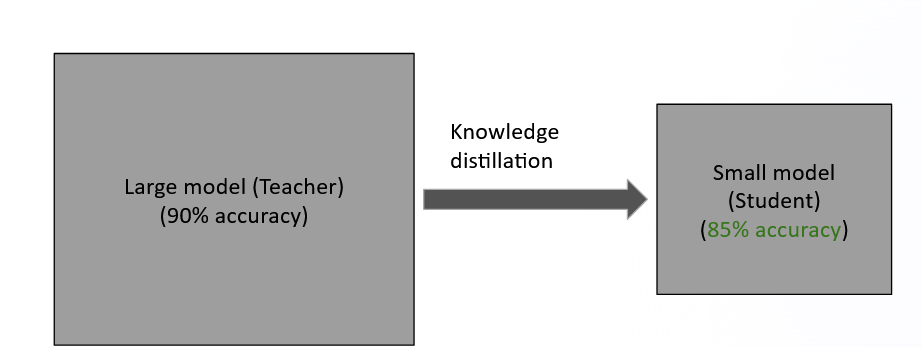

- With Knowledge Distillation you can produce a lightweight model which has small drop in performance to the bigger model.
- Faster inference that address cost, accessibility, and privacy issues

### Basic idea

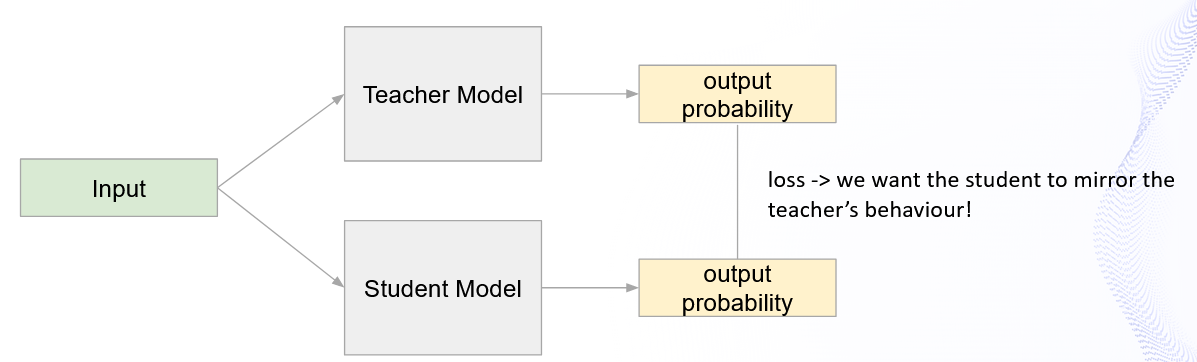

We try to make the output distribution of a student SIMILAR to its teacher's performance.

We do this by computing the distance between the student and student's output(s) and MINIMIZE IT!

Several distance metrics:

1. MSE (input: logits)
2. KL-Divergence (input: probability)


# NOW LET'S HAVE OUR HAND DIRTY!

## Plan

We will do distillation in Encoder Model

Data: **emotion dataset**

Teacher model: **BERT-base**

Student model: **Smaller BERT**

### Benchmark

1. Teacher model Accuracy
2. Student model Accuracy (without KD)
3. Student model Accuracy (with KD)


## Let's implement it

In [36]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
import lightning as L
from transformers import AutoTokenizer, DataCollatorWithPadding
from torchmetrics import F1Score
from torch import nn
import torch
from torch.utils.data import DataLoader
from copy import deepcopy
from lightning import Trainer, seed_everything

In [37]:
seed_everything(42)

Global seed set to 42


42

We just load it normally using `datasets`

In [2]:
dataset = load_dataset("dair-ai/emotion")

In [3]:
num_label = len(set(dataset['train']['label']))
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

In [12]:
data_train = dataset['train']
data_dev = dataset['validation']
data_test = dataset['test']

In [13]:
def tokenize(x, tokenizer):
    return tokenizer(x['text'])

In [14]:
data_train = data_train.map(lambda x: tokenize(x, tokenizer_bert), batched=True)
data_dev = data_dev.map(lambda x: tokenize(x, tokenizer_bert), batched=True)
data_test = data_test.map(lambda x: tokenize(x, tokenizer_bert), batched=True)


In [15]:
data_train = data_train.remove_columns(['text'])
data_dev = data_dev.remove_columns(['text'])
data_test = data_test.remove_columns(['text'])

## Define the Finetune Scenario

In [16]:
class FTModel(L.LightningModule):

    def __init__(self, model, lr: float, num_label: int = 6):
        super().__init__()
        self.model = model
        self.lr = lr
        self.ce_loss = nn.CrossEntropyLoss()
        self.train_f1 = F1Score('multiclass', num_classes=num_label, average='micro')
        self.val_f1 = F1Score('multiclass', num_classes=num_label, average='micro')
        self.test_f1 = F1Score('multiclass', num_classes=num_label, average='micro')

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.train_f1(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.val_f1(y_hat, y)
        self.log("f1_val_step", self.val_f1, on_epoch=True, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.test_f1(y_hat, y)
        self.log("f1_test_step", self.test_f1, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [17]:
lit_teacher_model = FTModel(model_bert, lr=1e-5, num_label=num_label)

In [26]:
train_dl = DataLoader(data_train, batch_size=64, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert), shuffle=True)
dev_dl = DataLoader(data_dev, batch_size=64,  collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert))
test_dl = DataLoader(data_test, 64, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert))

Check first!


In [27]:
batch = next(iter(train_dl))
batch.pop('labels')
lit_teacher_model(**batch)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


SequenceClassifierOutput(loss=None, logits=tensor([[-0.0729,  0.3586, -0.2291,  0.3896,  0.2199, -0.3069],
        [-0.2301,  0.4311, -0.0158,  0.2833,  0.3651, -0.2994],
        [ 0.2274,  0.4404, -0.2560,  0.3437,  0.3811, -0.2531],
        [-0.0074,  0.4230, -0.2151,  0.2803,  0.4100, -0.3294],
        [ 0.0181,  0.4198, -0.2242,  0.4688,  0.2233, -0.2560],
        [-0.0513,  0.3684, -0.2049,  0.3593,  0.1980, -0.3192],
        [ 0.2530,  0.3148, -0.2552,  0.2655,  0.4121, -0.2790],
        [ 0.1346,  0.5630, -0.1409,  0.3792,  0.2598, -0.1809],
        [ 0.0961,  0.3448, -0.1909,  0.3525,  0.2820, -0.2013],
        [ 0.2078,  0.3987, -0.3158,  0.3422,  0.2743, -0.2317],
        [ 0.4020,  0.3374, -0.3689,  0.4386,  0.2031, -0.1673],
        [-0.0330,  0.4436, -0.0457,  0.4203,  0.2678, -0.2060],
        [ 0.1038,  0.4014, -0.2068,  0.2662,  0.3432, -0.3206],
        [-0.1788,  0.3421,  0.0156,  0.2712,  0.3887, -0.3542],
        [-0.0649,  0.4461, -0.2326,  0.2837,  0.4142, -0.3672

Initialize the Trainer

In [35]:
trainer = Trainer(max_epochs=3, accelerator="gpu", devices=1, precision="16-mixed")

trainer.fit(lit_teacher_model, train_dl, dev_dl)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                          | Params
-----------------------------------------------------------
0 | model    | BertForSequenceClassification | 109 M 
1 | ce_loss  | CrossEntropyLoss              | 0     
2 | train_f1 | MulticlassF1Score             | 0     
3 | val_f1   | MulticlassF1Score             | 0     
4 | test_f1  | MulticlassF1Score             | 0     
-----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.947   Total estimated model params size (MB)


/home/haryoaw/mambaforge/envs/sensei/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   2%|▏         | 6/250 [00:15<10:16,  2.53s/it, v_num=1, train_loss=1.620]

I don't think we're going to wait.. Let's just download the model that I have prepared.
We will use DVC here.

In [ ]:
lit_teacher_model = FTModel.load_from_checkpoint("teacher/epoch=3-val_loss=0.16-f1_val_step=0.92.ckpt", model=model_bert, lr=None)

We check the performance

In [ ]:
trainer.test(lit_teacher_model, test_dl)

## Lets precompute to save time

In [ ]:
train_dl_for_out = DataLoader(data_train, batch_size=64, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert), shuffle=False)

In [ ]:
lit_teacher_model.eval()
lit_teacher_model = lit_teacher_model.cuda()
out_aggregated = []
with torch.no_grad():
    for x in tqdm(train_dl_for_out):
        out = lit_teacher_model(**x.to("cuda"))
        out_aggregated.append(out.logits.cpu().detach())
out_aggregated = torch.cat(out_aggregated)
save_file({'proba': out_aggregated}, "teacher_proba.safetensors")


## Let's train a small model?

In [ ]:
model_smol_cfg = deepcopy(model_bert.config)

In [ ]:
model_smol_cfg = deepcopy(model_bert.config)
model_smol_cfg.num_hidden_layers = 3
model_smol_cfg.num_attention_heads = 2
small_scratch_model = AutoModelForSequenceClassification.from_config(model_smol_cfg)

In [ ]:
lit_small_model = FTModel(small_scratch_model, 1e-5)

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath="student_scratch/",
                                      filename='{epoch}-{val_loss:.2f}-{f1_val_step:.2f}',
                                      save_top_k=1,
                                      monitor="f1_val_step", mode="max")
ea_stop = EarlyStopping(patience=3, monitor="f1_val_step", mode="max")
rich = RichProgressBar()
trainer = Trainer(callbacks=[checkpoint_callback, ea_stop, rich],accelerator='gpu', 
                  devices=1, precision=16, val_check_interval=100, check_val_every_n_epoch=None)
trainer.fit(lit_small_model, train_dl, dev_dl)

In [ ]:
# If you load from best checkpoint: checkpoint_callback.best_model_path

In [ ]:
lit_small_model = FTModel.load_from_checkpoint(checkpoint_callback.best_model_path, model=small_scratch_model, lr=None)
trainer.test(lit_small_model, test_dl)

Finally, Let's create a KD class

In [ ]:
class KDModel(L.LightningModule):

    def __init__(self, model, lr: float, weight_default_loss=1, weight_kd_loss=1, teacher_model=None, use_hidden=False):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_default_loss = weight_default_loss
        self.weight_kd_loss = weight_kd_loss
        self.ce_loss = CrossEntropyLoss()
        self.mse_loss = MSELoss()
        self.train_f1 = F1Score('multiclass', num_classes=6, average='macro')
        self.val_f1 = F1Score('multiclass', num_classes=6, average='macro')
        self.test_f1 = F1Score('multiclass', num_classes=6, average='macro')
        self.teacher_model = None
        self.use_hidden = use_hidden
        if teacher_model is not None and use_hidden:
            self.teacher_model = teacher_model
            self.teacher_model.eval()
            self.teacher_model.requires_grad_(False)
            
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        y = batch.pop('labels')
        teacher_proba = batch.pop("teacher_proba", default=None)
        out = self.model(**batch, output_hidden_states=True)
        y_hat = out.logits
        loss_kd = self.mse_loss(y_hat, teacher_proba)
        if self.teacher_model is not None and self.use_hidden:
            y_hat_hidden_states = out.hidden_states
            out_teacher_model = self.teacher_model(**batch, output_hidden_states=True)
            sum_hidden_loss = 0
            for std_hid, tch_hid in zip(y_hat_hidden_states, out_teacher_model.hidden_states[::3]):
                sum_hidden_loss += self.mse_loss(std_hid, tch_hid)
            loss_kd += sum_hidden_loss
        loss = self.ce_loss(y_hat,y)
        total_loss = loss + loss_kd 

        self.train_f1(y_hat, y)
        self.log("f1_step", self.train_f1, on_step=True, on_epoch=True)
        self.log("train_loss", total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.val_f1(y_hat, y)
        self.log("f1_val_step", self.val_f1, on_epoch=True, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.test_f1(y_hat, y)
        self.log("f1_test_step", self.test_f1, on_epoch=True, prog_bar=True)
        return loss

    def on_save_checkpoint(self, checkpoint):
        state_dict = checkpoint['state_dict']
        if 'teacher_model' in state_dict:
            state_dict.pop('teacher_model')
        checkpoint['state_dict'] = state_dict

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model_smol_cfg = deepcopy(model_bert.config)
model_smol_cfg.num_hidden_layers = 3
model_smol_cfg.num_attention_heads = 2
small_scratch_model = AutoModelForSequenceClassification.from_config(model_smol_cfg)

data_train_for_kd = data_train.add_column('teacher_proba', out_aggregated.numpy().tolist())

In [ ]:
kd_model = KDModel(small_scratch_model, 1e-5)

In [ ]:
data_train_for_kd = data_train.add_column('teacher_proba', out_aggregated.numpy().tolist())

In [ ]:
train_dl_for_kd = DataLoader(data_train_for_kd, batch_size=64, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert))

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath="kd_output_label/",
                                      filename='{epoch}-{val_loss:.2f}-{f1_val_step:.2f}',
                                      save_top_k=1,
                                      monitor="f1_val_step", mode="max")
ea_stop = EarlyStopping(patience=5, monitor="f1_val_step", mode="max")
rich = RichProgressBar()
trainer = Trainer(callbacks=[checkpoint_callback, ea_stop, rich],accelerator='gpu', 
                  devices=1, precision=16, val_check_interval=100, check_val_every_n_epoch=None)

In [ ]:
trainer.fit(kd_model, train_dl_for_kd, dev_dl)

In [ ]:
kd_model = KDModel.load_from_checkpoint(checkpoint_callback.best_model_path, model=small_scratch_model, lr=None)

In [ ]:
trainer.test(kd_model, test_dl)

How to do feature-based distillation?